In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import re
import pdb
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rc
rc('text', usetex=False)
from matplotlib.colors import to_rgb

from skimage.transform import resize
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim

from polyphase.parallel import get_distance_matrix

# laplacian eigenmaps
from sklearn.manifold import spectral_embedding, MDS, Isomap
from sklearn.cluster import spectral_clustering
from scipy.sparse import csgraph
from scipy.linalg import eigvalsh

In [3]:
# load the csv file with HTE data
allsys_df = pd.read_pickle('../expts/data/allsys_df.pkl')
htedf = pd.read_pickle('../data/htev2.pkl')
htedf.head()

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
0,Acetone,PC61BM,MDMO-PPV,0.440066,1.478520,1.90338,"[1626.0162601626018, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.62, 5.28]"
1,Acetone,PC61BM,MEH-PPV,0.458907,1.532581,1.90338,"[948.509485094851, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.38, 5.44]"
2,Acetone,PC61BM,P3HT,0.630290,2.719685,1.90338,"[117.82726522917405, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.56, 2.88, 3.19]"
3,Acetone,PC61BM,PFO,0.660927,2.507620,1.90338,"[1200.4944610849618, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.55, 2.8, 4.51]"
4,Acetone,PC61BM,PM6,0.468860,1.896708,1.90338,"[1436.3143631436315, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.37, 4.36, 4.19]"


In [4]:
def get_batch_of_phasediags(df, smstr, polymerstr):
    sys_df = df[(df['SM']==smstr) & (df['polymer']==polymerstr)]
    filename_list = []
    for _,row in sys_df.iterrows():
        fname = '../figures/hteplotsV2/{}_{}_{}.png'.format(row['solvent'], row['SM'], row['polymer'])
        filename_list.append(fname)
    
    return filename_list, sys_df

def get_ssim_distance(file0, file1):
    """ Given two image file names in file0, file1 compute distance"""
    
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    d = ssim(img0, img1, multichannel=True)
    
    return 1-d

from skimage.color import rgb2gray

def get_grayscale_ssim(file0, file1):
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    img0= rgb2gray(img0)
    img1= rgb2gray(img1)
    d = ssim(img0, img1)
    
    return 1-d

In [5]:
print('small molecules : ',  htedf['SM'].unique())
print('polymers: ', htedf['polymer'].unique())

small molecules :  ['PC61BM' 'PC71BM' 'DPP(TBFu)2' 'DPP(PhTT)2' 'Y6' 'IDTBR' 'IDIC']
polymers:  ['MDMO-PPV' 'MEH-PPV' 'P3HT' 'PFO' 'PM6' 'PTB7-Th']


from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(1,2, dpi=300)
fig.subplots_adjust(wspace=0.5)
im = axs[0].imshow(M, cmap='bwr')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
axs[0].set_title('SSIM')

im = axs[1].imshow(X, cmap='bwr')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
axs[1].set_title('Affinity')

#plt.savefig('../figures/notebooks/PC61BM_PM6_Y6_PM6_heatmap.png', dpi=500, bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(1,2, dpi=300)
fig.subplots_adjust(wspace=0.5)

axs[0].hist(M.flatten())
axs[0].set_title('SSIM')

axs[1].hist(X.flatten())
axs[1].set_title('Affinity')

#plt.savefig('../figures/notebooks/PC61BM_PM6_Y6_PM6.png', dpi=500, bbox_inches='tight')
plt.show()

In [6]:
# With just a pre-compute distance matrix

with open('../expts/data/chispace_dimred_mp10.pkl', 'rb') as handle:
    out = pickle.load(handle)
M = out['M']
delta = M.std()
X = np.exp(- M ** 2 / (2. * delta ** 2))
print(X.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../expts/data/chispace_dimred_mp10.pkl'

# Dimensionality reduction

## Multi dimensional scaling (MDS)
Since we have a metric from SSIM of phase diagrams, we can run the `metric multi-dimensional scaling` that tries to preserve the similarities between the data and embedding.

In [ ]:
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
def plot_embedding(embedding):

    fig = px.scatter(sys_df, x=embedding[:,0], y=embedding[:,1],
                     color=sys_df['delta_solv'].apply(lambda x: norm(x)), hover_data=['solvent','SM','polymer'],
                     color_continuous_scale=px.colors.sequential.RdBu
                    )
    fig.update_traces(marker=dict(size=12))
    fig.update_layout(coloraxis_colorbar=dict(title="Total solvent solubility"),
        plot_bgcolor='rgba(0,0,0,0)',yaxis = dict(showline=True)
                     )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black',
                    ticks="outside", tickwidth=2, ticklen=10)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                    ticks="outside", tickwidth=2, ticklen=10)
    fig.update_layout(
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
    )
    
    return fig

In [ ]:
embedding = MDS(n_components=3,  dissimilarity='precomputed', metric=True, random_state=0)
emb_mds = embedding.fit_transform(M)

# fig = plot_embedding(emb_mds)
# fig.show()

##  ISOMAP

Compute `isometric projection` of graph based geodesics into a two-dimensional euclidean space by `metric MDS`.

In [38]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform

embedding = Isomap(n_components=3,n_neighbors=5, metric='precomputed')
embedding.fit(M)
Dm = embedding.dist_matrix_
emb_isomap = embedding.embedding_

explained_variance = []
for dim in [1,2,3]:
    Dy = squareform(pdist(emb_isomap[:,:dim]))
    explained_variance.append(pearsonr(Dm.flatten(), Dy.flatten())[0])

# fig = plot_embedding(emb_isomap)
# fig.update_xaxes(title=r"Coordinate 1 ({:.2f}%)".format(explained_variance[0]*100))
# fig.update_yaxes(title=r"Coordinate 2 ({:.2f}%)".format(explained_variance[1]*100))

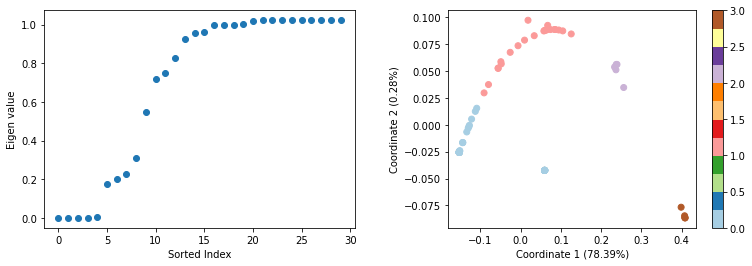

In [40]:
from sklearn.cluster import SpectralClustering
from scipy.spatial.distance import pdist, squareform

NUM_CLUSTERS = 4
clustering = SpectralClustering(n_clusters=NUM_CLUSTERS,assign_labels="discretize",random_state=0, affinity='precomputed')
D = squareform(pdist(emb_mds, 'euclidean'))
delta = 0.01
A = np.exp(- D ** 2 / (2. * delta ** 2))
lowdim_labels = clustering.fit_predict(A)

laplacian = csgraph.laplacian(A, normed=True)
eigen_values = eigvalsh(laplacian)

fig, axs = plt.subplots(1,2, figsize=(2*4*1.6, 4))
fig.subplots_adjust(wspace=0.3)

num_eigs = 30
axs[0].scatter(np.arange(num_eigs),eigen_values[:num_eigs])
axs[0].set_xlabel('Sorted Index')
axs[0].set_ylabel('Eigen value')

pos = axs[1].scatter(emb_isomap[:,0], emb_isomap[:,1], c = lowdim_labels, cmap=plt.cm.Paired)
fig.colorbar(pos, ax=axs[1])
axs[1].set_xlabel(r"Coordinate 1 ({:.2f}%)".format(explained_variance[0]*100))
axs[1].set_ylabel(r"Coordinate 2 ({:.2f}%)".format((explained_variance[1]-explained_variance[0])*100))

plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(x=emb_mds[:,0], y=emb_mds[:,1], z=emb_mds[:,2],color=highdim_labels)
fig2 = px.scatter_3d(x=emb_mds[:,0], y=emb_mds[:,1], z=-0.5*np.ones(len(emb_mds)),color=highdim_labels, opacity=0.2)
fig.add_trace(fig2.data[0])
fig.show()

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_clustered_diagrams_grid(cluster_id, labels):
    cluster_diags = sys_df.loc[labels==cluster_id]
    num_diags = len(cluster_diags)
    fig = plt.figure(dpi=250)
    N = int(np.floor(np.sqrt(num_diags)))
    grid = ImageGrid(fig, 111,nrows_ncols=(N, N), axes_pad=(0.1,0.1))
    for ax, (_,row) in zip(grid, cluster_diags.iterrows()):
        fname = '../figures/hteplotsV2/{}_{}_{}.png'.format(row['solvent'],row['SM'],row['polymer'])
        img = plt.imread(fname)
        ax.imshow(img)
        ax.axis('off')
    fig.suptitle('{}/{} diagrams left out'.format(np.abs(num_diags-N**2),num_diags))
    plt.axis('off')
    plt.show()

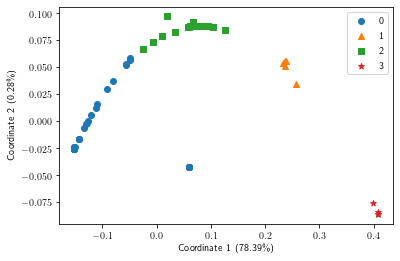

In [51]:
from matplotlib import rcParams
rcParams.update({"text.usetex": True})
highdim_labels = clustering.fit_predict(X)
fig, ax = plt.subplots()
label_markers = ['o','^','s','*']
for i in np.unique(highdim_labels):
    ax.scatter(emb_isomap[highdim_labels==i,0], emb_isomap[highdim_labels==i,1], 
               marker=label_markers[i], label=str(i))
ax.legend()                                                                                            
ax.set_xlabel(r"Coordinate 1 ({:.2f}\%)".format(explained_variance[0]*100))
ax.set_ylabel(r"Coordinate 2 ({:.2f}\%)".format((explained_variance[1]-explained_variance[0])*100))
plt.savefig('../figures/notebooks/PM6_Y6_DR.png', dpi=300, bbox_inches='tight')
plt.show()


array([0, 1, 2, 3])

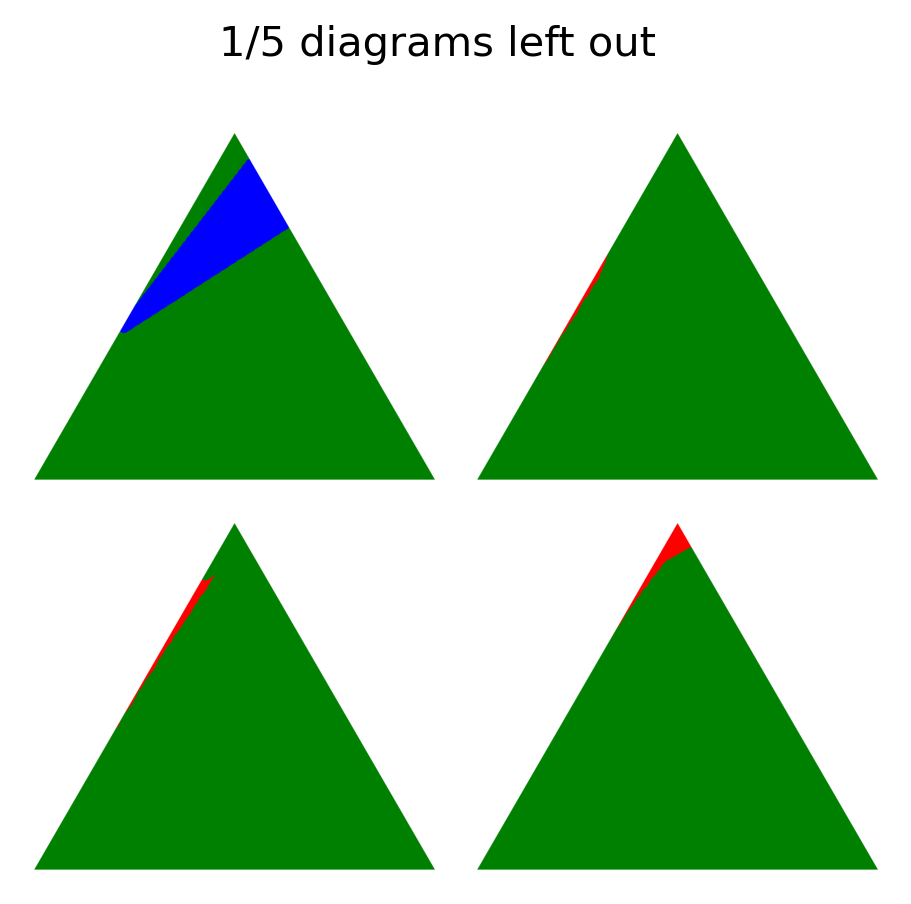

In [15]:
plot_clustered_diagrams_grid(3, highdim_labels)

PM6_PC61BM 86
PM6_Y6 86


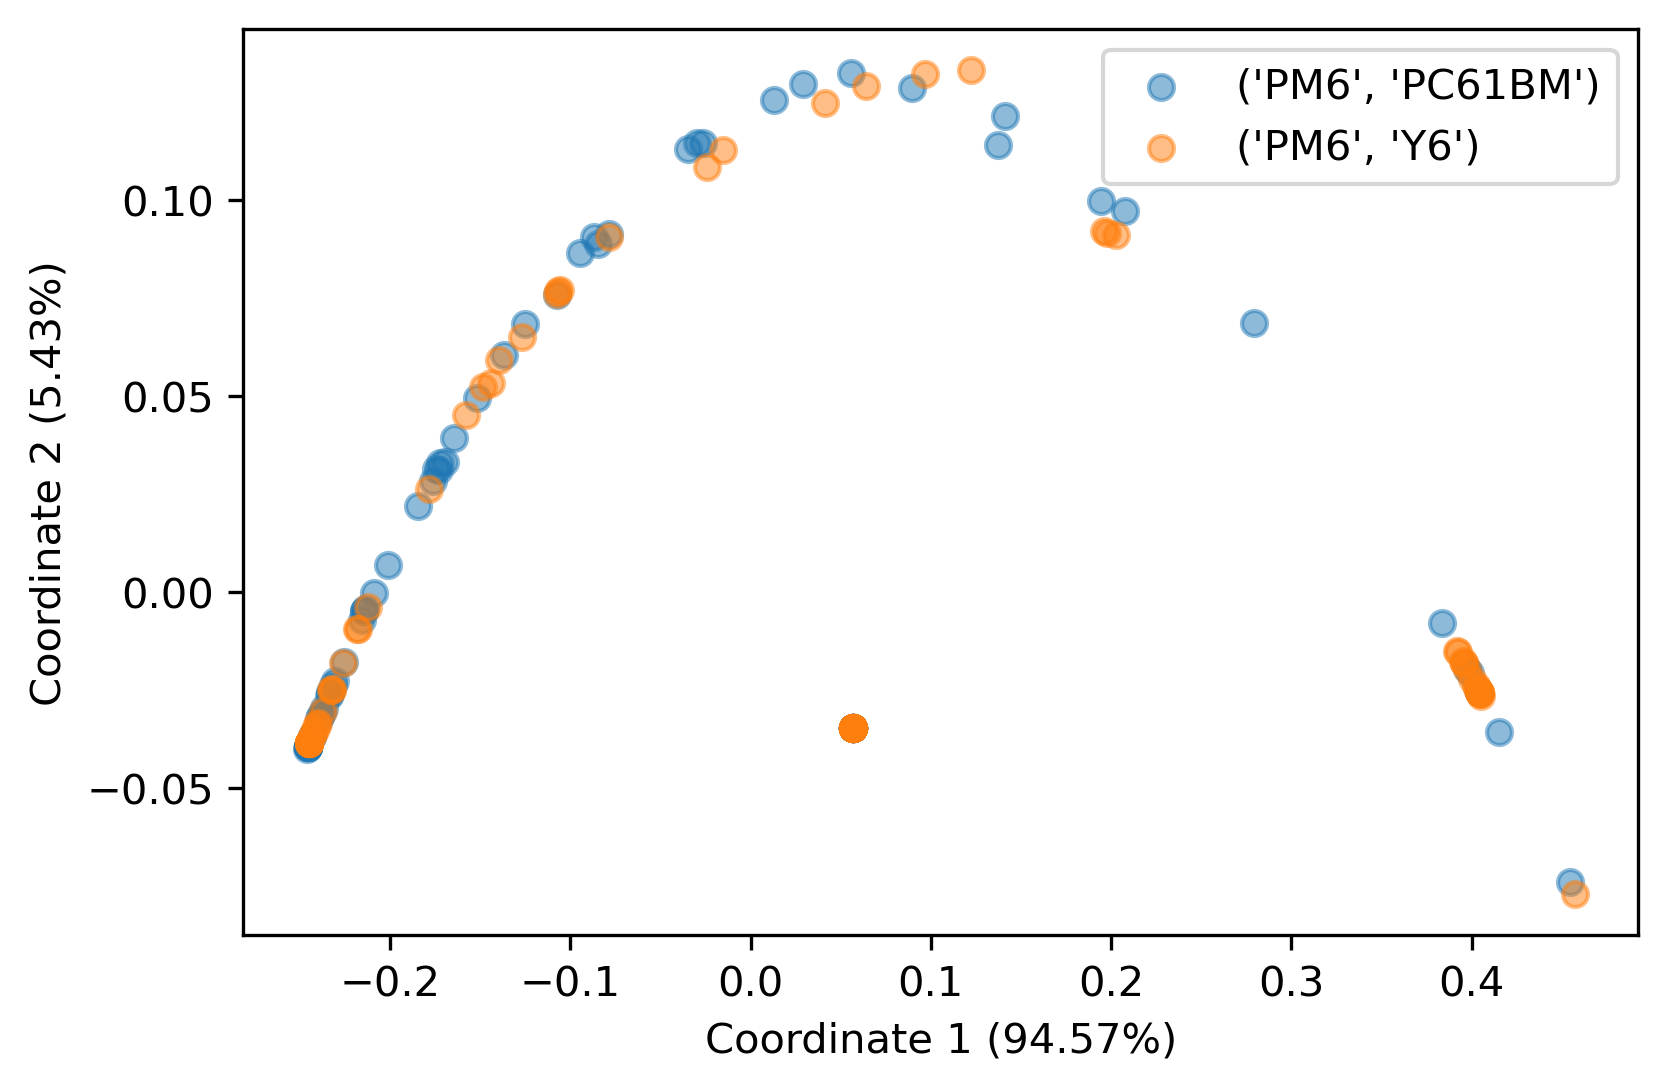

In [86]:
# differentiate embeddings of two systems
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel(r"Coordinate 1 ({:.2f}%)".format(explained_variance[0]*100))
ax.set_ylabel(r"Coordinate 2 ({:.2f}%)".format(explained_variance[1]*100))

for sys, df  in sys_df.groupby(['polymer', 'SM']):
    sys_name = '_'.join(i for i in sys)
    print(sys_name, len(df))
    ax.scatter(emb_isomap[df.index,0], emb_isomap[df.index,1],label=sys,alpha=0.5)
ax.legend()
plt.show()
